# Question 2: DH algorithm (50 points)
**In this question we are going to implement the DH algorithm according to the paper https://icml.cc/Conferences/2008/papers/324.pdf and try to predict protein localization sites in Eukaryotic cells.**

### Imports

In [55]:
import copy
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import choice
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import optim


# provided custom modules
from provided.update_empirical import update_empirical
from provided.best_pruning_and_labeling import best_pruning_and_labeling
from provided.assign_labels import assign_labels
from provided.get_leaves import get_leaves


# setup
seed = 2021
warnings. filterwarnings("ignore")

## Part 2.0 Data loading and hierarchical clustering
**The DH algorithm is based on hierarchical clustering of the dataset. We will use the DH algorithm on this classification problem: [Protein Localization Prediction](https://archive.ics.uci.edu/ml/datasets/Yeast).**

**The first step is to load the dataset and conduct a hierarchical clustring using the `Scipy` package. This part has been implemented, read through the code to make sure you understand what is being done.**

**NOTES:**
- **X_train: data matrix 1200x8**
- **Y_train: true labels 1200x1**
- **X_test: data matrix 284x8**
- **Y_test: true labels 284x1**

**TIPS:**
- **Check out this [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) for details about hierarchical clustering.**
- **If you are unfamiliar with hierarchical clustering using scipy, [this](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/ ) is another helpful resource. (We won't use dendrograms here, but he gives a nice explanation of how to interpret the linkage matrix).**
               

### Explore data

In [61]:
df =  pd.read_csv('data/data.csv')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Label
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [62]:
np.unique(df.Label, return_counts=True)

(array(['MIT', 'NUC'], dtype=object), array([244, 429]))

### Load data

In [ ]:

# X_train, y_train, X_test, y_test, T = load_data('data/data.csv', seed=seed, filter_class=['MIT', 'NUC'])


In [63]:
df = pd.read_csv('data/testdata.csv')
df = df[:5]
df

,X1,X2,X3,X4,X5,X6,X7,X8,Label
0,0.58,0.61,0.47,0.13,0.5,0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0,0.54,0.22,NUC
4,0.58,0.44,0.57,0.13,0.5,0,0.54,0.22,MIB


In [64]:
filter_class = ['MIT','NUC']
print(filter_class)
mask = df.Label == 0
print('mask before')
print(mask)
print()
for x in filter_class:
#     print(x)
#     print(df.Label == x)
#     print()
    mask = mask | (df.Label == x)
print('mask after')
print(mask)
print()
df.head()

['MIT', 'NUC']
mask before
0    False
1    False
2    False
3    False
4    False
Name: Label, dtype: bool

mask after
0     True
1     True
2     True
3     True
4    False
Name: Label, dtype: bool



,X1,X2,X3,X4,X5,X6,X7,X8,Label
0,0.58,0.61,0.47,0.13,0.5,0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0,0.54,0.22,NUC
4,0.58,0.44,0.57,0.13,0.5,0,0.54,0.22,MIB


In [65]:
df = df[mask]
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Label
0,0.58,0.61,0.47,0.13,0.5,0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0,0.54,0.22,NUC


In [78]:

# 
X = df.iloc[:, :8].to_numpy()
print(X.shape)
#
y = df.Label.astype('category').cat.codes.to_numpy()
print(y.shape)

#
# X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
a = X.astype('float')
a.dtype


(4, 8)
(4,)


dtype('float64')

4
[[0.58 0.61 0.47 0.13 0.5  0.   0.48 0.22]
 [0.43 0.67 0.48 0.27 0.5  0.   0.53 0.22]
 [0.64 0.62 0.49 0.15 0.5  0.   0.53 0.22]
 [0.58 0.44 0.57 0.13 0.5  0.   0.54 0.22]]

[[0.         2.         0.083666   2.        ]
 [3.         4.         0.23366643 3.        ]
 [1.         5.         0.30149627 4.        ]]


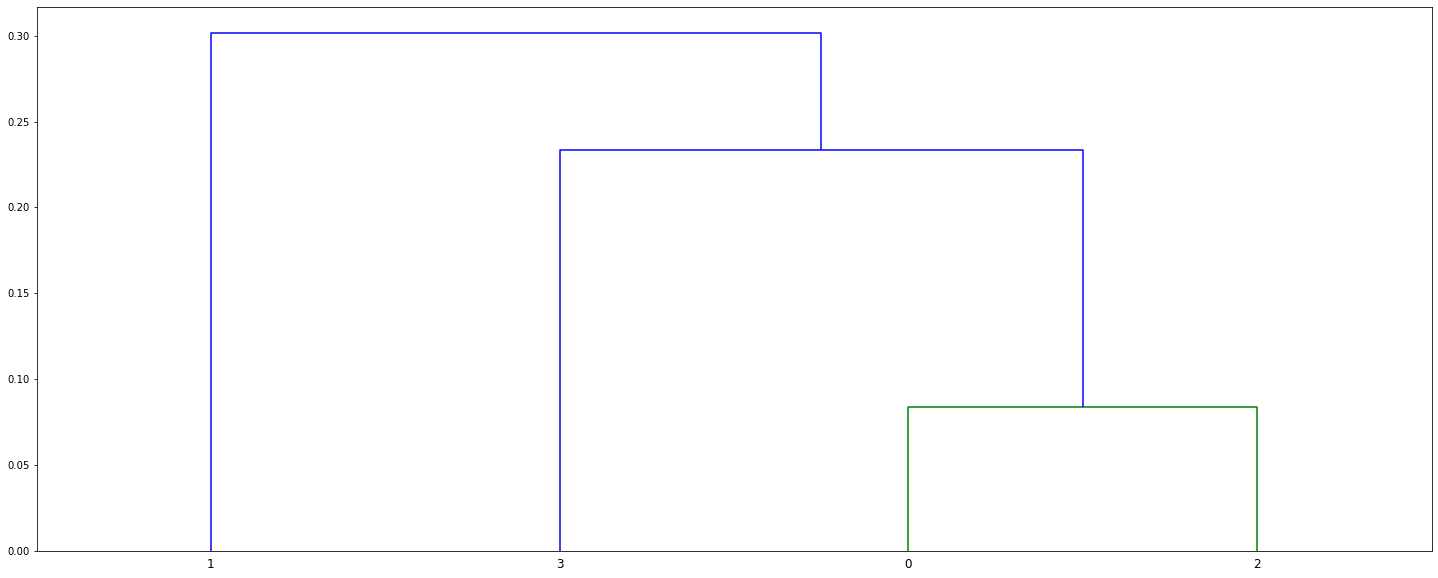

In [67]:
#
n_samples = len(X)
print(n_samples)
print(X)
print()
Z = linkage(X, method='ward')
print(Z)
fig = plt.figure(figsize=(25,10))
dn = dendrogram(Z)
plt.show()


In [68]:
link = Z[:, :2].astype(int)
link

array([[0, 2],
       [3, 4],
       [1, 5]])

In [69]:
link[-1, -1]

5

In [71]:
subtree_sizes = np.zeros(link[-1, -1] + 2)
print(subtree_sizes)
subtree_sizes[:n_samples] = 1
subtree_sizes

[0. 0. 0. 0. 0. 0. 0.]


array([1., 1., 1., 1., 0., 0., 0.])

In [72]:
parent = {}
parent[2 * (n_samples - 1)] = 0  # set root node as 0
parent

{6: 0}

In [75]:
for i in range(len(link)):
    left = link[i, 0]
    print('left',left)
    right = link[i, 1]
    print('right',right)
    current = i + n_samples
    print('parent',current)
    subtree_sizes[current] = subtree_sizes[left] + subtree_sizes[right]
    parent[left] = current
    parent[right] = current
    
parent
subtree_sizes

# T = [link, subtree_sizes, parent]

left 0
right 2
parent 4
left 3
right 4
parent 5
left 1
right 5
parent 6


array([1., 1., 1., 1., 2., 3., 4.])

# Part 2.0.1 Supervised classification methods.
**TODO:**
- **Initialize a classifier**

**We provide several classifiers that can be used. Choose your favourite one. To use the Neural Network classifier, you need to install [pytorch](https://pytorch.org/).**

In [ ]:
## Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

## Random Forest
N_estimator_rf = 20
MAX_depth_rf = 6
rf = RandomForestClassifier(n_estimators = N_estimator_rf, 
                            max_depth = MAX_depth_rf, random_state = seed)
rf.fit(X_train, y_train)

## Gradient Boosting Decision Tree
N_estimator_gbdt = 20
gbdt_max_depth = 6
gbdt = GradientBoostingClassifier(n_estimators = N_estimator_gbdt,
                                 learning_rate = 0.1,
                                 max_depth = gbdt_max_depth,
                                 random_state = seed)
gbdt.fit(X_train,y_train)

## 3-Layer fully connected NN

torch.manual_seed(seed)
class NNClassifier(object):
    def __init__(self,
                 feature_n,
                 class_n,
                 hidden_n = 30,
                 learning_rate = 4e-3,
                 weight_decay = 1e-5):
        self.model = torch.nn.Sequential(torch.nn.Linear(feature_n,hidden_n),
                                        torch.nn.SiLU(),
                                        torch.nn.Linear(hidden_n,hidden_n),
                                        torch.nn.SiLU(),
                                        torch.nn.Linear(hidden_n,class_n))
        self.lr = learning_rate
        self.wd = weight_decay
    def fit(self,X_train,y_train,epoches = 300,batch_size = 50):
        X_t = torch.from_numpy(X_train.astype(np.float32))
        y_t = torch.from_numpy(y_train.astype(np.int64))
        dataset = TensorDataset(X_t,y_t)
        loader = DataLoader(dataset,batch_size = batch_size,shuffle = True)
        loss_fn = torch.nn.CrossEntropyLoss(reduction = 'mean')
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr,weight_decay=self.wd)
        loss_record = 0.0
        report_epoch = 50
        for epoch_i in range(epoches):
            for batch in loader:
                x_batch,y_batch = batch
                y_pred = self.model(x_batch)
                loss = loss_fn(y_pred,y_batch)
                self.model.zero_grad()
                loss.backward()
                optimizer.step()
                loss_record += loss.item()
            if epoch_i%report_epoch == report_epoch-1:
                print("[%d|%d] epoch loss:%.2f"%(epoch_i+1,epoches,loss_record/report_epoch))
                loss_record = 0.0
            if epoch_i>=epoches:
                break
    
    def score(self,X_test,y_test):
        X_test_tensor = torch.from_numpy(X_test.astype(np.float32))
        y_pred_test = self.model(X_test_tensor)
        y_output = torch.argmax(y_pred_test,axis = 1).numpy()
        return (y_output == y_test).mean()
        
nn = NNClassifier(feature_n = X_train.shape[1],class_n = len(np.unique(y_train)))
nn.fit(X_train,y_train)

## Accuracy of 4 classifiers.
print('Accuracy of logistic regression: \t{:.3f}'.format(lr.score(X_test,y_test)))
print('Accuracy of random forest: \t\t{:.3f}'.format(rf.score(X_test,y_test)))
print('Accuracy of Gradient Boosting Decision Tree: \t\t{:.3f}'.format(gbdt.score(X_test,y_test)))
print('Accuracy of Neural Network: \t\t{:.3f}'.format(nn.score(X_test,y_test)))

### Choose and initialize your classifier:
The classifier is going to be used in 2.2, the choose of classifier won't influence your grade

In [ ]:
#TODO: Uncomment one line to choose your classifier.
#classifier = LogisticRegression()

#classifier = RandomForestClassifier(n_estimators = N_estimator_rf,max_depth = MAX_depth_rf, random_state = seed)

#classifier = GradientBoostingClassifier(n_estimators = N_estimator_gbdt,
#                                 learning_rate = 0.1,
#                                 max_depth = gbdt_max_depth,
#                                 random_state = seed)

#classifier = NNClassifier(feature_n = X_train.shape[1],class_n = len(np.unique(y_train)))


## Part 2.1 Implement DH algorithm (Hierarchical Sampling for Active Learning). (30 points)

**TODO:**
- **Please complete the functions to implement the DH algorithm and run the active learning algorithm on the training dataset.**
- **The utils functions has been implemented and attached in the homework folder, including `update_empirical.py`, `best_pruning_and_labeling.py`, `assign_labels.py`, and `get_leaves.py`. Please read them and finish the following functions to implement the DH algorithm.**

In [ ]:
def compute_error(L,labels):
    """Compute the error

    :param L: labeling of leaf nodes
    :param labels: true labels of each node

    :returns error: error of predictions"""

    wrong = 0
    wrong = (L[:len(labels)]!=labels).sum()
    error = wrong/len(labels)
    return error

def select_case_1(data,labels,T,budget,batch_size):
    """DH algorithm where we choose P proportional to the size of subtree rooted at each node

    :param data: Data matrix 1200x8
    :param labels: true labels 1200x1
    :param T: 3 element tree
        T[0] = linkage matrix from hierarchical clustering.  See https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
               for details. If you are unfamiliar with hierarchical clustering using scipy, the following is another helpful resource (We won't use dendrograms
               here, but he gives a nice explanation of how to interpret the linkage matrix):
               https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/ 

        T[1] = An array denoting the size of each subtree rooted at node i, where i indexes the array.  
               ie. The number of all children + grandchildren + ... + the node itself

        T[2] = dict where keys are nodes and values are the node's parent
    :param budget: Number of iterations to make 
    :param batch_size: Number of queries per iteration"""

    n_nodes = len(T[1]) #total nodes in T
    n_samples = len(data) #total samples in data
    L = np.zeros(n_nodes) #majority label
    p1 = np.zeros(n_nodes) #empirical label frequency
    n = np.zeros(n_nodes) #number of points sampled from each node
    error = []#np.zeros(n_samples) #error at each round
    root = n_nodes-1 #corresponds to index of root
    P = np.array([root])
    L[root] = 1    
    
    for i in range(budget):
        selected_P = []
        for b in range(batch_size):

            #TODO: select a node from P proportional to the size of subtree rooted at each node
            raise(NotImplemetedError)
            
            ##TODO: pick a random leaf node from subtree Tv and query its label

            #TODO: update empirical counts and probabilities for all nodes u on path from z to v

        for p in selected_P:
            #TODO: update admissible A and compute scores; find best pruning and labeling
            raise(NotImplemetedError)
            #TODO: update pruning P and labeling L

        #TODO: temporarily assign labels to every leaf and compute error
        L_temp = L.copy()
        raise(NotImplemetedError)

    for i in range(len(P)):
        L = assign_labels(L,P[i],P[i],T,n_samples)
    
    return L, np.array(error)

def select_case_2(data,labels,T,budget,batch_size):
    """DH algorithm where we choose P by biasing towards choosing nodes in areas where the observed labels are less pure

    :param data: Data matrix 1200x8
    :param labels: true labels 284x1
    :param T: 3 element tree
        T[0] = linkage matrix from hierarchical clustering.  See https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
               for details. If you are unfamiliar with hierarchical clustering using scipy, the following is another helpful resource (We won't use dendrograms
               here, but he gives a nice explanation of how to interpret the linkage matrix):
               https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/ 

        T[1] = An array denoting the size of each subtree rooted at node i, where i indexes the array.  
               ie. The number of all children + grandchildren + ... + the node itself

        T[2] = dict where keys are nodes and values are the node's parent
    :param budget: Number of iterations to make 
    :param batch_size: Number of queries per iteration"""

    n_nodes = len(T[1]) #total nodes in T
    n_samples = len(data) #total samples in data
    L = np.zeros(n_nodes,dtype = int) #majority label
    p1 = np.zeros(n_nodes) #empirical label frequency
    n = np.zeros(n_nodes) #number of points sampled from each node
    error = []#np.zeros(n_samples) #error at each round
    root = n_nodes-1 #corresponds to index of root
    P = np.array([root])
    L[root] = 1    

    for i in range(budget):
        selected_P = []
        for b in range(batch_size):
            #TODO: select a node from P biasing towards choosing nodes in areas where the observed labels are less pure
            raise(NotImplemetedError)
            
            #TODO: pick a random leaf node from subtree Tv and query its label

            #TODO: update empirical counts and probabilities for all nodes u on path from z to v

        for p in selected_P:
            #TODO: update admissible A and compute scores; find best pruning and labeling
            raise(NotImplemetedError)
            #TODO: update pruning P and labeling L

        #TODO: temporarily assign labels to every leaf and compute error
        L_temp = L.copy()
        raise(NotImplemetedError)
        
    for i in range(len(P)):
        L = assign_labels(L,P[i],P[i],T,n_samples)
        
    return L, np.array(error)                


## Part 2.2 Run the sample code (10 points)
**TODO:**
- **Run the following sample code and compare the two figures.**

In [ ]:
def call_DH(part,clf,budget):
    """Main function to run all your code once complete.  After you complete
       select_case_1() and select_case_2(), this will run the DH algo for each 
       dataset and generate the plots you will submit within your write-up.

       :param part: which part of the homework to run
       :param clf: The classifier used to predcit on the dataset.
       :param budget: The number of times that one can query a label from the oracle.
    """
    
    part = part.lower()
    num_trials = 5
    batch_size = 10
    clf2 = copy.deepcopy(clf)
    axs = plt.subplot()
    if part == "b":
        print("Running part B")
        X_train, y_train, X_test, y_test, T = load_data()
        l = np.zeros(budget)
        for i in range(num_trials):
            print("Currently on iteration {}".format(i))
            L, error = select_case_1(X_train,y_train,T,budget,batch_size)
            l += error 
        l /= num_trials
        
        ## TODO: train the classifier clf on the predicted label.
        #raise(NotImplementedError)
        clf.fit(X_train,L[:len(X_train)])
        
        print('Accuracy of classifier trained on random sampling dataset: \t{:.3f}'.format(clf.score(X_test,y_test)))
        axs.plot(np.arange(budget),l,label = "Random sampling")

    elif part == "c":
        print("Running part C")
        X_train, y_train, X_test, y_test, T = load_data()
        l = np.zeros(budget)
        for i in range(num_trials):
            print("Currently on iteration {}".format(i))
            L, error = select_case_2(X_train,y_train,T,budget,batch_size)
            l += error 
        l /= num_trials
        
        ## TODO: train the classifier clf2 on the predicted label.
        #raise(NotImplementedError)
        clf2.fit(X_train,L[:len(X_train)])
        
        print('Accuracy of classifier trained on active learning dataset: \t{:.3f}'.format(clf2.score(X_test,y_test)))
        axs.plot(np.arange(budget),l,label = "Active learning")

    else:
        print("Incorrect part provided. Either 'b', 'c', 'd', or 'e' expected")
    axs.set_ylim([0,0.5])
    axs.set_xlabel("Number of query samples")
    axs.set_ylabel("Error rate")
    plt.legend()
    plt.savefig("q2_2.png")
BUDGET = 200 #You can change this number to a smaller one during testing.
for part in "bc":
    call_DH(part,classifier,BUDGET)


## Part 2.3 Questions (10 points):
**TODO:**
- **Answer the following questions.**
### What is a "admissible pair" according to the paper (5 points)?
### Please explain the sampling bias that is dealt with in the DH algorithm and why it would be a problem if we just query the unlabeled point which is closest to the decision boundary (5 points)?